In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import load_model

Using TensorFlow backend.


Read in the data.

In [4]:
train_set = pd.read_csv('train_set_metadata.csv')
test_set = pd.read_csv('test_set_metadata.csv')

X_test = np.load('test_set_hmgd_arr.npy')

model_A1 = load_model('regression_epoch_044.hdf5')
model_A2 = load_model('regression_rescaling_epoch_044.hdf5')

Compute predictions.

In [5]:
model_A1_preds = model_A1.predict(255 * X_test).ravel()
model_A2_preds = model_A2.predict(X_test).ravel()
ensemble_preds = (model_A1_preds + model_A2_preds) / 2

# free up memory
del X_test

Compute the mean absolute error per age and the number of photographs in the train set per age.

In [6]:
age_values = np.sort(test_set['age'].unique())
age_predictions = pd.Series(ensemble_preds)

mean_abs_error_per_age = []
n_photos_in_train_set_per_age = []

for fixed_age in age_values:
    indx = (test_set['age'] == fixed_age)    
    
    mean_abs_error = np.abs(test_set.loc[indx, 'age'] - age_predictions[indx]).mean()
    mean_abs_error_per_age.append(mean_abs_error)
    
    n_photos_in_train_set_per_age.append((train_set['age'] == fixed_age).sum())

mean_abs_error_per_age = np.asarray(mean_abs_error_per_age)
n_photos_in_train_set_per_age = np.asarray(n_photos_in_train_set_per_age)

Visualize the results and compute the correlation of these variables.

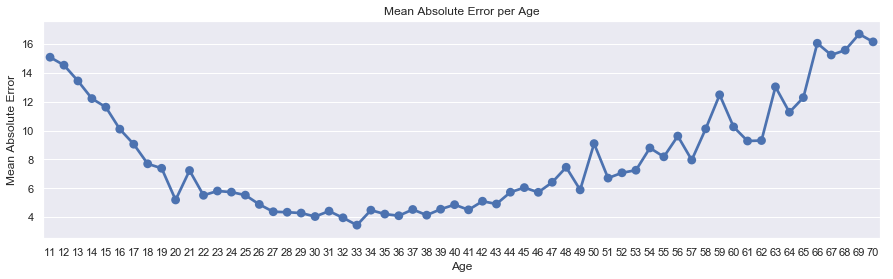

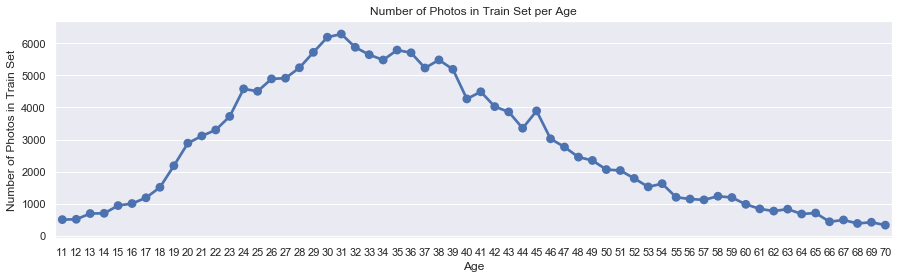

In [7]:
plt.figure(figsize=(15, 4))
sns.pointplot(age_values, mean_abs_error_per_age)
plt.xlabel('Age')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error per Age')
plt.show()

plt.figure(figsize=(15, 4))
sns.pointplot(age_values, n_photos_in_train_set_per_age)
plt.xlabel('Age')
plt.ylabel('Number of Photos in Train Set')
plt.title('Number of Photos in Train Set per Age')
plt.show()

In [8]:
pd.DataFrame({'mae_per_age': mean_abs_error_per_age, 
              'n_photos_per_age': n_photos_in_train_set_per_age}).corr().round(4)

,mae_per_age,n_photos_per_age
mae_per_age,1.0000,-0.8653
n_photos_per_age,-0.8653,1.0000


Now, we can clearly see that the mean absolute error increases dramatically as the number of photos decreases. Furthermore, the correlation coefficient of -0.8653 quantifies this relationship as strong. This explains to some extent the abysmal performance of the model for those age values that are highly underrepresented in the train set.

If we restrict our attention to, say, the \[26, 45\] age bracket, which is well represented in the train set, the model predictions improve substantially. Below we compute the mean absolute error for this age bracket and present a couple of visualizations of predictions vs. actual age values.

In [9]:
indx = test_set['age'].between(26, 45)
mean_abs_error = np.abs(test_set.loc[indx, 'age'] - age_predictions[indx]).mean()
print(f'Mean absolute error: {mean_abs_error}')

Mean absolute error: 4.463158439295714


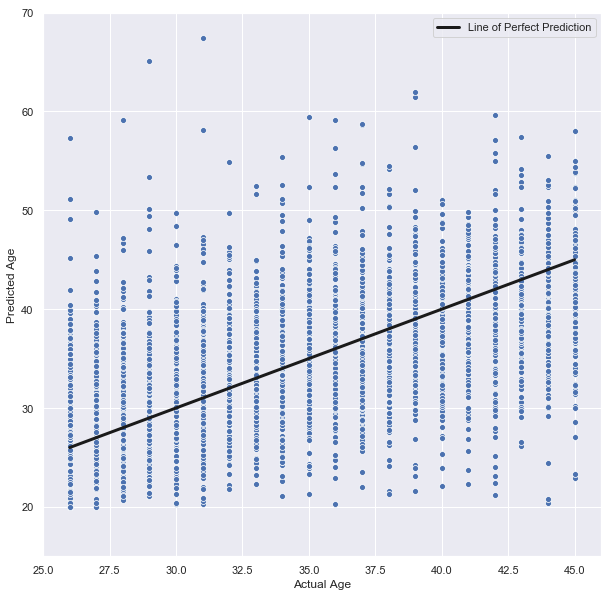

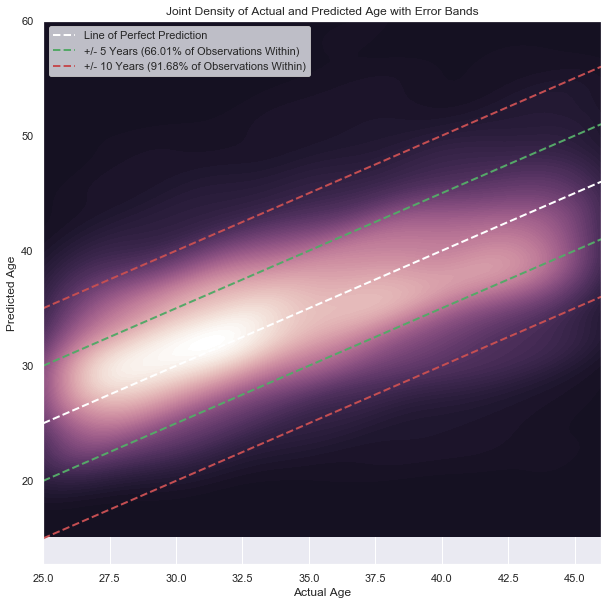

In [21]:
#Scatterplot
plt.figure(figsize=(10, 10))
plt.plot([26, 45], [26, 45], 'k', linewidth=3, label='Line of Perfect Prediction')
sns.scatterplot(test_set.loc[indx, 'age'], age_predictions[indx])
plt.xlim((25, 46))
plt.ylim((15, 70))
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend()
plt.show()


#Density plot with error bands
within_5_years = (np.abs(test_set.loc[indx, 'age'] - age_predictions[indx]) <=5).mean()
within_5_years = np.round(100 * within_5_years, 2)
within_10_years = (np.abs(test_set.loc[indx, 'age'] - age_predictions[indx]) <=10).mean()
within_10_years = np.round(100 * within_10_years, 2)

plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0.075, light=1, reverse=True)
sns.kdeplot(test_set.loc[indx, 'age'], age_predictions[indx], 
            cmap=cmap, n_levels=100, shade=True, clip=[(25, 46), (15, 60)])
plt.plot([25, 46], [25, 46], 'w--', linewidth=2, 
         label='Line of Perfect Prediction')
plt.plot([25, 46], [30, 51], 'g--', linewidth=2, 
         label=f'+/- 5 Years ({within_5_years}% of Observations Within)')
plt.plot([25, 46], [20, 41], 'g--', linewidth=2)
plt.plot([25, 46], [35, 56], 'r--', linewidth=2, 
         label=f'+/- 10 Years ({within_10_years}% of Observations Within)')
plt.plot([25, 46], [15, 36], 'r--', linewidth=2)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.legend(loc='upper left')
plt.title('Joint Density of Actual and Predicted Age with Error Bands')
plt.show()